In [21]:
from shapely.geometry import Polygon
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def list_to_coord(x):
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    
    x = [[x0, x2], [x1, x2], [x1, x3], [x0, x3]]
    return x

def calculate_iou(box_1, box_2):
    box_1 = list_to_coord(box_1)
    box_2 = list_to_coord(box_2)
    
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

def convert(x, label=True):
    x_min = int((float(x[1])-(float(x[3])/2))*640)
    x_max = int((float(x[1])+(float(x[3])/2))*640)

    y_min = int((float(x[2])-(float(x[4])/2))*640)
    y_max = int((float(x[2])+(float(x[4])/2))*640)
    
    if not label:
        return x_min, x_max, y_min, y_max
    else:
        return x_min, x_max, y_min, y_max, int(x[0])
    
def calculate_area(prediction):
    return (prediction[1] - prediction[0] + 1) * (prediction[3] - prediction[2] + 1)

In [22]:
def test_iou(save_area=False):
    collect_true = []
    collect_predicted = []

    best_iou = []

    for txt in sorted(os.listdir('runs/detect/exp8/labels/')):
        with open('final_augmented_data/test/labels/' + txt) as f:
            true_labels = list(map(lambda x: x[:-2].split(), f.readlines()))
        with open('runs/detect/exp8/labels/' + txt) as t:
            predicted_labels = list(map(lambda x: x[:-2].split(), t.readlines()))

        correct_ious = []
        accurate = False

        for true in true_labels:
            for predict in predicted_labels:
                if true[0] == predict[0]:
                    accurate = True
                    correct_ious.append([calculate_iou(convert(true), convert(predict)), true[0], calculate_area(convert(predict))])

        correct_ious = np.array(correct_ious, dtype=float)

        if not accurate:
            best_iou.append([0, int(true[0]), 0])
        else:
            best_iou.append(correct_ious[np.argmax(correct_ious[:, 0])])
    return best_iou

In [23]:
ious = pd.DataFrame(test_iou(), columns=['iou', 'label', 'area'])   
ious

,iou,label,area
0,0.911017,12.0,1845.0
1,0.888889,11.0,1224.0
2,0.904722,1.0,2408.0
3,0.836237,11.0,1517.0
4,0.963781,2.0,12540.0
...,...,...,...
5063,0.871287,12.0,4100.0
5064,0.823848,11.0,1932.0
5065,0.962812,12.0,3200.0
5066,0.885357,0.0,11421.0


In [24]:
ious.groupby('label')['iou'].mean()

label
0.0     0.871891
1.0     0.840646
2.0     0.893000
3.0     0.858639
4.0     0.843841
5.0     0.841095
6.0     0.873054
7.0     0.827050
8.0     0.902139
9.0     0.861367
10.0    0.889383
11.0    0.850859
12.0    0.854315
13.0    0.808131
Name: iou, dtype: float64

In [25]:
ious['area'] = np.log(ious['area'])

/anaconda/envs/py38_default/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


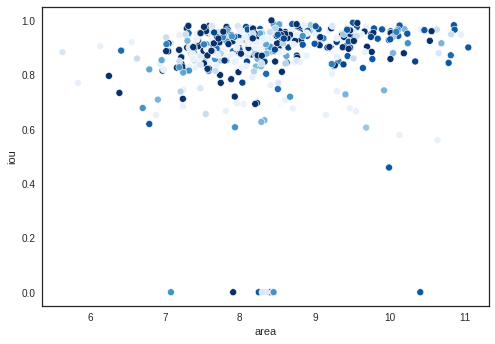

In [26]:
plt.style.use('seaborn-white')
sns.scatterplot(x='area', y='iou', hue='label', data=ious.sample(500), legend=False, palette='Blues_r')
plt.savefig('area')

## Performance Analysis

###### How good is the algorithm at locating secondary objects?

In [27]:
collect_true = []
collect_predicted = []

for txt in sorted(os.listdir('runs/detect/exp8/labels/')):
    with open('final_augmented_data/test/labels/' + txt) as f:
        true_labels = list(map(lambda x: x[:-2].split(), f.readlines()))
    with open('runs/detect/exp8/labels/' + txt) as t:
        predicted_labels = list(map(lambda x: x[:-2].split(), t.readlines()))
            
    #filter only for images that contain multiple labels
    if np.array(true_labels).shape[0] > 1:
        collect_true.append(true_labels)
        collect_predicted.append(predicted_labels)
        
        


In [28]:
#among all the pairwise comparisons, save the second best of iou of the correctly predicted labels

image = 0

second = []

while image != len(collect_true):
    first = False
    for true in collect_true[image]:
        for predict in collect_predicted[image]:
            if true[0] == predict[0]:
                if not first:
                    iou = calculate_iou(convert(true), convert(predict))
                    if iou != 0:
                        second.append([iou, convert(true)[-1]])
                        
                first = True
                
    image += 1

In [29]:
second = pd.DataFrame(np.array(second), columns=['iou', 'label'])
second.head()

,iou,label
0,0.911017,12.0
1,0.931490,12.0
2,0.662121,13.0
3,0.885437,12.0
4,0.781145,12.0


In [30]:
ious['type'] = 'first'
second['type'] = 'second'

([<matplotlib.axis.XTick at 0x7f8de33f7460>,
 [Text(0.0, 0, 'Adidas'),
  Text(1.0, 0, 'Apple'),
  Text(2.0, 0, 'Coca Cola'),
  Text(3.0, 0, 'Emirates'),
  Text(4.0, 0, 'Hard Rock Cafe'),
  Text(5.0, 0, 'Mercedes Benz'),
  Text(6.0, 0, 'NFL'),
  Text(7.0, 0, 'Nike'),
  Text(8.0, 0, 'Pepsi'),
  Text(9.0, 0, 'Puma'),
  Text(10.0, 0, 'Starbucks'),
  Text(11.0, 0, 'The North Face'),
  Text(12.0, 0, 'Toyota'),
  Text(13.0, 0, 'Under Armour')])

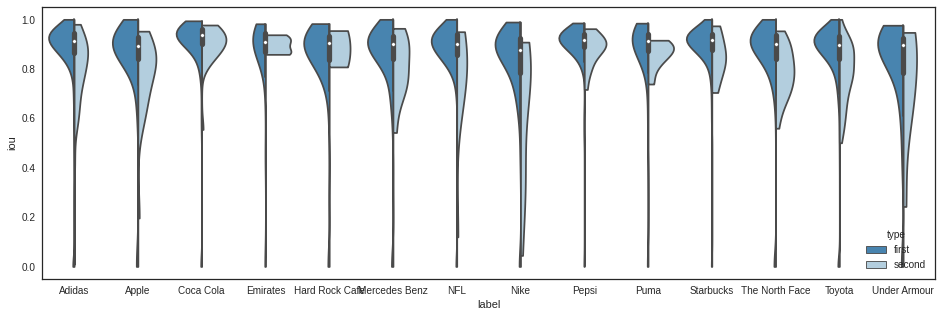

In [38]:
fig = plt.figure(figsize=(16, 5))
violin = pd.concat([ious, second])
sns.violinplot(x='label', y='iou', hue='type', data=violin, palette='Blues_r', split=True, cut=0, legend=False)
plt.xticks(ticks=list(set(violin['label'])), labels=['Adidas', 'Apple', 'Coca Cola', 'Emirates', 'Hard Rock Cafe',
                                                    'Mercedes Benz', 'NFL', 'Nike', 'Pepsi', 'Puma', 'Starbucks',
                                                    'The North Face', 'Toyota', 'Under Armour'])


(0.9, 0.8)

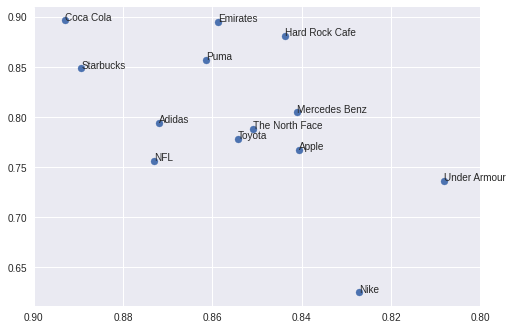

In [12]:
plt.style.use('seaborn')

labels = ['Adidas', 'Apple', 'Coca Cola', 'Emirates', 'Hard Rock Cafe',
                                                    'Mercedes Benz', 'NFL', 'Nike', 'Pepsi', 'Puma', 'Starbucks',
                                      'The North Face', 'Toyota', 'Under Armour']

scatter = violin.pivot_table(index='label', values='iou', columns='type')

x = scatter['first']
y = scatter['second']

plt.scatter(x, y)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))
    
plt.xlim(0.9, 0.8)


In [13]:
collect_true = []
collect_predicted = []

x1 = 320
y1 = 320

best_iou = []

for txt in sorted(os.listdir('runs/detect/exp8/labels/')):
    with open('final_augmented_data/test/labels/' + txt) as f:
        true_labels = list(map(lambda x: x[:-2].split(), f.readlines()))
    with open('runs/detect/exp8/labels/' + txt) as t:
        predicted_labels = list(map(lambda x: x[:-2].split(), t.readlines()))

    correct_ious = []
    accurate = False

    for true in true_labels:
        for predict in predicted_labels:
            if true[0] == predict[0]:
                accurate = True
                x2 = ((convert(true)[1] - convert(true)[0]) // 2) + convert(true)[0]
                y2 = ((convert(true)[3] - convert(true)[2]) // 2) + convert(true)[2]
                correct_ious.append([calculate_iou(convert(true), convert(predict)), true[0], calculate_area(convert(predict)), np.sqrt((x2 - x1)**2 + (y2 - y1)**2)**(1/2)])

    correct_ious = np.array(correct_ious, dtype=float)

    if not accurate:
        best_iou.append([0, int(true[0]), 0, 0])
    else:
        best_iou.append(correct_ious[np.argmax(correct_ious[:, 0])])

In [14]:
best_iou

[array([9.11016949e-01, 1.20000000e+01, 1.84500000e+03, 1.01980390e+01]),
 array([8.88888889e-01, 1.10000000e+01, 1.22400000e+03, 3.62669911e+00]),
 array([9.04722452e-01, 1.00000000e+00, 2.40800000e+03, 1.81333278e+01]),
 array([8.36236934e-01, 1.10000000e+01, 1.51700000e+03, 1.33442951e+01]),
 array([9.63781062e-01, 2.00000000e+00, 1.25400000e+04, 1.51075779e+01]),
 array([9.19723678e-01, 1.20000000e+01, 4.14100000e+03, 1.89169376e+01]),
 array([  0.93149038,  12.        , 832.        ,  16.19936763]),
 array([9.30970724e-01, 2.00000000e+00, 3.13200000e+03, 1.51764902e+01]),
 array([8.74591312e-01, 1.30000000e+01, 4.25600000e+03, 5.34796216e+00]),
 array([8.61136999e-01, 1.30000000e+01, 2.24200000e+03, 1.73791951e+01]),
 array([9.47905248e-01, 2.00000000e+00, 2.07090000e+04, 1.62843812e+01]),
 array([9.74683544e-01, 1.20000000e+01, 7.12000000e+03, 1.41358559e+01]),
 array([9.22024084e-01, 1.10000000e+01, 1.48750000e+04, 1.62481351e+01]),
 array([8.97815363e-01, 1.20000000e+01, 3.9600

In [15]:
ious = pd.DataFrame(best_iou, columns=['iou', 'label', 'area', 'distance'])   
ious.head()

,iou,label,area,distance
0,0.911017,12.0,1845.0,10.198039
1,0.888889,11.0,1224.0,3.626699
2,0.904722,1.0,2408.0,18.133328
3,0.836237,11.0,1517.0,13.344295
4,0.963781,2.0,12540.0,15.107578


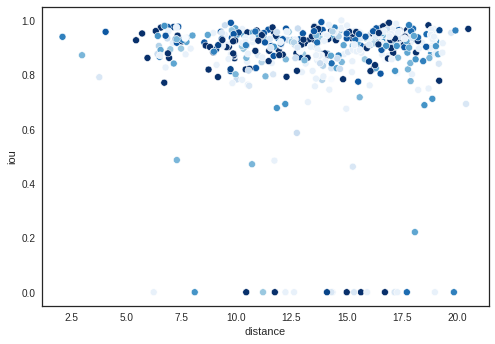

In [18]:
plt.style.use('seaborn-white')

sns.scatterplot(x='distance', y='iou', hue='label', data=ious.sample(500), legend=False, palette='Blues_r')
plt.savefig('distance')